<a href="https://colab.research.google.com/github/Phantom1502/Deep-Learning/blob/main/Predict_Stock_Price_version_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import output
output.enable_custom_widget_manager()

#Config drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

import os
os.chdir('/content/gdrive/My Drive/')

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

Mounted at /content/gdrive/


In [2]:
xauusd_df = pd.read_csv("./data/train_XAUUSD.csv")
xauusd_data = xauusd_df[xauusd_df.columns[0:12]].to_numpy()
xauusd_label = xauusd_df[xauusd_df.columns[12:15]].to_numpy()

eurusd_df = pd.read_csv("./data/train_EURUSD.csv")
eurusd_data = eurusd_df[eurusd_df.columns[0:12]].to_numpy()
eurusd_label = eurusd_df[eurusd_df.columns[12:15]].to_numpy()

gbpusd_df = pd.read_csv("./data/train_GBPUSD.csv")
gbpusd_data = gbpusd_df[gbpusd_df.columns[0:12]].to_numpy()
gbpusd_label = gbpusd_df[gbpusd_df.columns[12:15]].to_numpy()

raw_data = np.concatenate((xauusd_data, eurusd_data, gbpusd_data), axis=0)
raw_label = np.concatenate((xauusd_label, eurusd_label, gbpusd_label), axis=0)

#raw_data = xauusd_data
#raw_label = xauusd_label

In [3]:
def convert__to_digital(data):
    step = 16
    ranges = []
    distance = 2. / step
    
    result = np.zeros((len(data), 12 * (step + 1)))
    for k,items in enumerate(data):
        for i,item in enumerate(items):
            for j in range(step + 1):
                if item < (j - step/2) * distance + distance/2:
                    result[k][i * 5 + j] = 1
                    break
    return result


def normallize_price(data):
    result = np.zeros((len(data), 12))
    for i in range(len(data)):
        # convert price to range [-1, 1]
        min_price = min(data[i])
        max_price = max(data[i])
        result[i] = data[i] - (max_price + min_price)/2
        result[i] = 2 * result[i]/(max_price - min_price)
    return result

norm_data = normallize_price(raw_data)
data = convert__to_digital(norm_data)
label =  np.asarray(raw_label).astype('float32')

data_train, data_test, label_train, label_test = train_test_split(data, label, test_size=0.20, shuffle = False)
print(data_train.shape)
print(data_test.shape)

(102794, 204)
(25699, 204)


In [3]:
def normallize_price(data):
    mean = data.mean(axis=1)
    std = data
    for i in range(len(data)):
        mean = data[i].mean()
        data[i] -= mean
        std = data[i].std()
        data[i] /= std
    return data

data = normallize_price(raw_data)
label =  np.asarray(raw_label).astype('float32')

data_train, data_test, label_train, label_test = train_test_split(data, label, test_size=0.20, shuffle = False)

In [4]:
from keras import models
from keras import layers
from keras import regularizers

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(data_train.shape[1],)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(data_train, label_train, epochs=400, batch_size=256, validation_data=[data_test, label_test])

Epoch 1/400
402/402 [==============================] - 3s 5ms/step - loss: 0.9783 - accuracy: 0.5009 - val_loss: 0.9672 - val_accuracy: 0.4953
Epoch 2/400
402/402 [==============================] - 1s 4ms/step - loss: 0.9612 - accuracy: 0.5015 - val_loss: 0.9662 - val_accuracy: 0.4883
Epoch 3/400
402/402 [==============================] - 1s 4ms/step - loss: 0.9579 - accuracy: 0.5014 - val_loss: 0.9643 - val_accuracy: 0.4928
Epoch 4/400
402/402 [==============================] - 2s 4ms/step - loss: 0.9555 - accuracy: 0.5019 - val_loss: 0.9642 - val_accuracy: 0.4952
Epoch 5/400
402/402 [==============================] - 1s 4ms/step - loss: 0.9538 - accuracy: 0.5021 - val_loss: 0.9690 - val_accuracy: 0.4910
Epoch 6/400
402/402 [==============================] - 2s 4ms/step - loss: 0.9512 - accuracy: 0.5023 - val_loss: 0.9692 - val_accuracy: 0.4868
Epoch 7/400
402/402 [==============================] - 2s 4ms/step - loss: 0.9492 - accuracy: 0.5037 - val_loss: 0.9686 - val_accuracy: 0.4943

Test 1:
- Data Gold
- Preprocess: Normalize
- Result: loss: loss: 0.6733 - accuracy: 0.6937 - val_loss: 1.5001 - val_accuracy: 0.4472
---
Test 2:
- Data All
- Preprocess: Normalize
- Result: loss: 0.8859 - accuracy: 0.5541 - val_loss: 1.1344 - val_accuracy: 0.4660
---
Test 3:
- Data All
- Preprocess: Hot Encode
- Result: loss: 0.7199 - accuracy: 0.6674 - val_loss: 1.4930 - val_accuracy: 0.4295
---
Test 4:
- Data Gold
- Preprocess: Hot Encode
- Result: loss: 0.2675 - accuracy: 0.8913 - val_loss: 4.5428 - val_accuracy: 0.3985

The argument being passed to each Dense layer (16) is the number of hidden
units of the layer. A hidden unit is a dimension in the representation space of the layer.
You may remember from chapter 2 that each such Dense layer with a relu activation
implements the following chain of tensor operations:
output = relu(dot(W, input) + b)
Having 16 hidden units means the weight matrix W will have shape (input_dimension,
16): the dot product with W will project the input data onto a 16-dimensional representation space (and then you’ll add the bias vector b and apply the relu operation).

In [ ]:
model.save('./models/model_db_20_layer_09_22_2022.h5')

**Model Detail**
model.add(layers.Dense(4096, activation='relu', input_shape=(train_data.shape[1],)))

model.add(layers.Dense(4096, activation='relu'))

model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

**Lưu tại /models/model_db_09_22_2022.h5**

**loss: 0.1897 - accuracy: 0.9276**

**Model Summary:**

dense_9 (Dense)             (None, 4096)              53248     
                                                                 
dense_10 (Dense)            (None, 4096)              16781312  
                                                                 
dense_11 (Dense)            (None, 3)                 12291 

**Model Detail** 10 layers
model.add(layers.Dense(32, activation='relu', input_shape=(train_data.shape[1],)))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(128, activation='relu'))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(16, activation='relu'))

model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

**Lưu tại /models/model_db_10_layer_09_22_2022.h5**

**loss: 0.1173 - accuracy: 0.9577**

**Model Summary:**

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 dense_31 (Dense)            (None, 32)                416       
                                                                 
 dense_32 (Dense)            (None, 64)                2112      
                                                                 
 dense_33 (Dense)            (None, 128)               8320      
                                                                 
 dense_34 (Dense)            (None, 256)               33024     
                                                                 
 dense_35 (Dense)            (None, 256)               65792     
                                                                 
 dense_36 (Dense)            (None, 128)               32896     
                                                                 
 dense_37 (Dense)            (None, 64)                8256      
                                                                 
 dense_38 (Dense)            (None, 32)                2080      
                                                                 
 dense_39 (Dense)            (None, 16)                528       
                                                                 
 dense_40 (Dense)            (None, 3)                 51  


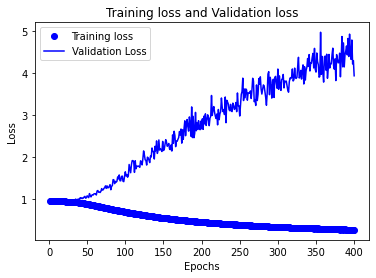

In [ ]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training loss and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()